In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import os
import re
import requests
import json
import yfinance as yf
from time import sleep
from tqdm import tqdm
from datetime import datetime as dt

Inputs

In [2]:
# Insert ticker below
ticker = "CHWY"

# Initialize years and quarters we wish to scrape
years = range(2000, 2026)
quarters = range(1, 5)
year_quarters = [f"{year}-year/{quarter}-quarter" for year in years for quarter in quarters]

# Base URL for earnings call transcripts
url_base = f"https://www.roic.ai/quote/{ticker}/transcripts/"

# Directory for saving ticker data 
ticker_dir = f"./earnings_calls/{ticker}/"


Scrape Earnings Calls for Ticker

In [3]:
def get_earnings_call_text(url: str):
    """
    This function takes in a url and scrapes the earnings call text using a chrome driver.
    The scrape simply copies the entire visible text from the page and parses out all of the text between "Earnings Call Transcript" and "Footer"

    Inputs:
    url (str): URL string to scrape

    Outputs:
    Parsed earnings call text
    """
    options = Options()
    options.headless = True
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        visible_text = driver.find_element("tag name", "body").text
        return visible_text.split('Earnings Call Transcript')[2].split('Footer')[0]
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None
    finally:
        driver.quit()

In [4]:
scraped_earnings_calls_dir = f"{ticker_dir}scraped_earnings_calls.csv"

if not os.path.exists(scraped_earnings_calls_dir):
    print(f"{scraped_earnings_calls_dir} does not exist, scraping earnings calls for {ticker}")
    os.makedirs(ticker_dir)

    scraped_earnings_calls = [get_earnings_call_text(f"{url_base}{yq}") for yq in year_quarters]

    scraped_earnings_calls_df = pd.DataFrame([year_quarters, scraped_earnings_calls]).T
    scraped_earnings_calls_df.columns = ['year_quarter', 'earnings_call_raw_text']
    
    scraped_earnings_calls_df.to_csv(f"{ticker_dir}scraped_earnings_calls.csv")
    earnings_call_df = scraped_earnings_calls_df
else:
    print(f"{scraped_earnings_calls_dir} exists, loading data from saved")
    earnings_call_df = pd.read_csv(f"{ticker_dir}scraped_earnings_calls.csv", index_col=0)

./earnings_calls/CHWY/scraped_earnings_calls.csv exists, loading data from saved


Analyze Sentiment Scores with Gemma-3-27B-it

In [5]:
prompt = """
I will provide the transcript of an earnings call. Your job is to analyze the text only based on what is actually present in the transcript. For each of the following categories, assign a score between -1 and 1:

forward_looking_sentiment: How positive or negative is the company’s outlook or projections for the future?

management_confidence: How confident does management appear about business performance and strategy?

risk_and_uncertainty: How much concern, risk, or uncertainty is conveyed (higher = more risk)?

qa_sentiment: How positive or negative is the tone during the Q&A section with analysts?

opening_sentiment: How positive or negative is the opening section or prepared remarks?

financial_performance_sentiment: Based solely on what is said in the transcript, how positively is past financial performance portrayed?

macroeconomic_reference_sentiment: If there are references to broader macroeconomic conditions, how optimistic or pessimistic are those?

If a category is not addressed clearly in the transcript, return exactly 0 for that category.

Use the following format for your output:
{{
  "forward_looking_sentiment": ___,
  "management_confidence": ___,
  "risk_and_uncertainty": ___,
  "qa_sentiment": ___,
  "opening_sentiment": ___,
  "financial_performance_sentiment": ___,
  "macroeconomic_reference_sentiment": ___
}}
Do not include any text or explanation—only return the JSON object. Do not guess or infer information that is not directly stated in the transcript.

{}
"""

score_columns = [
    "forward_looking_sentiment",
    "management_confidence",
    "risk_and_uncertainty",
    "qa_sentiment",
    "opening_sentiment",
    "financial_performance_sentiment",
    "macroeconomic_reference_sentiment"
]

url = "https://api.arliai.com/v1/chat/completions"

headers = {
  'Content-Type': 'application/json',
  'Authorization': f"Bearer {os.getenv('ARLIAI_API_KEY')}" # Replace with your actual API key
}

In [6]:
def get_sentiment_scores(earnings_call_raw_text: str):
    """
    This function takes the raw earnings call text and returns the following sentiment scores as a list:
    1. forward_looking_sentiment
    2. management_confidence
    3. risk_and_uncertainty
    4. qa_sentiment
    5. opening_sentiment
    6. financial_performance_sentiment
    7. macroeconomic_reference_sentiment

    The sentiment scores are generated via a Gemma-3-27B-it response via an ArliAI request

    Input:
    earnings_call_raw_text (str): raw text of the earnings call

    Output:
    score_list (list): List of float sentiment scores corresponding to the above categories
    """
    
    payload = {
        "model": "Gemma-3-27B-it",
        "messages": 
        [{"role": "user", "content": prompt.format(earnings_call_raw_text)}],
        "temperature": 0.0,
        "top_p": 1.0,
        "top_k": 1,
        "max_tokens": 512,
        "stream": False
    }
    
    response = requests.post(url, headers=headers, json=payload)
    
    raw_output = response.json()['choices'][0]['message']['content']
    
    # Remove the ```json ... ``` wrapper using regex
    json_str = re.sub(r"^```json\n|\n```$", "", raw_output.strip())
    
    # Parse the cleaned string into a Python dict
    score_dict = json.loads(json_str)
    
    # Extract just the values as a list
    score_list = list(score_dict.values())

    return score_list
    

def parse_quarter(quarter_str: str):
    """
    This function extracts the date from the year_quarter string

    Input: 
    quarter_str (str): year and quarter of earnings call
    
    Output: Timestamp representing the first day of the quarter
    """
    
    year, q = quarter_str.split("-year/")[0], quarter_str.split("/")[-1][0]
    month = {'1': 1, '2': 4, '3': 7, '4': 10}[q]
    
    return pd.Timestamp(f"{year}-{month:02d}-01")

In [7]:
earnings_calls_sentiment_dir = f"{ticker_dir}earnings_call_sentiment_data.csv"
if not os.path.exists(earnings_calls_sentiment_dir):
    print(f"{earnings_calls_sentiment_dir} does not exist, analyzing sentiment for {ticker}")

    results = []
    
    for transcript in tqdm(earnings_call_df['earnings_call_raw_text']):
        try:
            scores = get_sentiment_scores(transcript)  # your function
        except Exception as e:
            print(f"Error on transcript: {e}")
            scores = [0] * 7
    
        results.append(scores)
        sleep(0.5)
    
    scores_df = pd.DataFrame(results, columns=score_columns)
    
    earnings_call_df = pd.concat([earnings_call_df.reset_index(drop=True), scores_df], axis=1)

    earnings_call_df['date'] = earnings_call_df['year_quarter'].apply(parse_quarter)
    earnings_call_df.to_csv(earnings_calls_sentiment_dir)

else:
    print(f"{earnings_calls_sentiment_dir} exists, loading from saved")
    earnings_call_df = pd.read_csv(earnings_calls_sentiment_dir, index_col = 0)
    earnings_call_df['date'] = earnings_call_df['date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))


./earnings_calls/CHWY/earnings_call_sentiment_data.csv exists, loading from saved


In [8]:
earnings_call_df = earnings_call_df.dropna()
earnings_call_df['overall_sentiment'] = earnings_call_df[score_columns].mean(axis = 1)

price_df = yf.download(ticker, start=earnings_call_df['date'].min() - pd.Timedelta(days=10), end=earnings_call_df['date'].max() + pd.Timedelta(days=10))
price_df = price_df['Close']
price_df.index = pd.to_datetime(price_df.index)

first_trading_day = price_df.index.min()
last_trading_day = price_df.index.max()
trading_days = set(price_df.index)

def get_entry_date(d, timing="after"):
    # skip events outside price history
    if d < first_trading_day or d > last_trading_day:
        return pd.NaT
    
    # shift forward 1 day if after-hours
    if timing == "after":
        d += pd.Timedelta(days=1)
    
    # walk forward until we hit a trading day
    while d not in trading_days:
        d += pd.Timedelta(days=1)
    
    return d

# Apply function
earnings_call_df['entry_date'] = earnings_call_df['date'].apply(lambda d: get_entry_date(d, timing="after"))


/var/folders/fb/mvfcc8w97vb6v2m4gth004x80000gn/T/ipykernel_9255/2536359445.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(ticker, start=earnings_call_df['date'].min() - pd.Timedelta(days=10), end=earnings_call_df['date'].max() + pd.Timedelta(days=10))
[*********************100%***********************]  1 of 1 completed


In [ ]:

price_df

{'CAGR_strategy': np.float64(0.13246509556007147), 'Vol_annualized': np.float64(0.10644123524778214), 'Sharpe': np.float64(1.2218049093275727), 'MaxDD': np.float64(-0.1009372497676313), 'HitRate': np.float64(1.0), 'Exposure': np.float64(0.16535994297933002)}


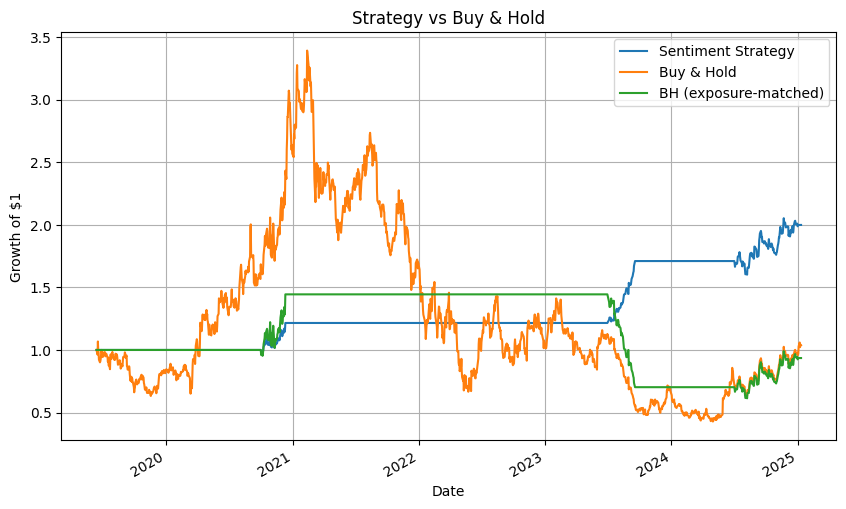

In [9]:
# --- Prep & signals ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sort events chronologically
ec = earnings_call_df.sort_values('date').copy()

# Expanding mean/std up to (but not including) current row (no look-ahead)
ec['mu']  = ec['overall_sentiment'].shift().expanding().mean()
ec['sig'] = ec['overall_sentiment'].shift().expanding().std()
ec['z_overall'] = (ec['overall_sentiment'] - ec['mu']) / (ec['sig'] + 1e-12)

# Signal from overall sentiment z-score
upper, lower = 1.0, -1.0  # try 0.5–1.5 in sweeps
ec['signal'] = 0
ec.loc[ec['z_overall'] >= upper, 'signal'] = 1
ec.loc[ec['z_overall'] <= lower, 'signal'] = -1

# Map each call date to the NEXT trading day as entry_date
px = price_df.iloc[:, 0].rename("Close")           # 1-D price Series (Date index)
trading_index = px.index

def next_trading_day(d):
    # if d is a trading day, enter next session; else bfill to next session
    if d in trading_index:
        i = trading_index.get_loc(d)
        return trading_index[min(i + 1, len(trading_index) - 1)]
    else:
        i = trading_index.get_indexer([d], method='bfill')[0]
        return trading_index[i]

ec['entry_date'] = ec['date'].apply(next_trading_day)

# --- Risk & sizing params ----------------------------------------------------
POSITION_SIZE = 0.50   # fraction of capital per trade
STOP_LOSS     = 0.20   # 20% sign-adjusted loss
TAKE_PROFIT   = 0.50   # 50% sign-adjusted gain
USE_TRAILING  = False
TRAIL_GIVEUP  = 0.10   # 10% giveback from max favorable move

# --- Build positions with hold-until-next-earnings + stops -------------------
pos = pd.Series(0.0, index=trading_index)
trade_entries, trade_exits, trade_pnls = [], [], []

rets = px.pct_change().fillna(0.0)
ec_sorted = ec.dropna(subset=['entry_date']).sort_values('entry_date')

for _, row in ec_sorted.iterrows():
    sig = row['signal']
    if sig == 0:
        continue

    entry = row['entry_date']
    # Default planned exit is next earnings entry_date (or last day)
    nxt  = ec_sorted.loc[ec_sorted['entry_date'] > entry, 'entry_date'].min()
    last = trading_index[-1]
    exit_plan = nxt if pd.notna(nxt) else last

    # Align to trading calendar (defensive)
    if entry not in trading_index:
        entry = trading_index[trading_index.get_indexer([entry], method='bfill')[0]]
    if exit_plan not in trading_index:
        exit_plan = trading_index[trading_index.get_indexer([exit_plan], method='bfill')[0]]

    entry_price = px.loc[entry]
    best_fav = 0.0
    actual_exit = exit_plan

    # Walk from entry to planned exit (inclusive), applying risk exits
    window = pos.loc[entry:exit_plan].index
    for d in window:
        pnl = sig * (px.loc[d] / entry_price - 1.0)  # sign-adjusted PnL
        if pnl > best_fav:
            best_fav = pnl

        stopped = False
        if pnl <= -STOP_LOSS:
            actual_exit = d; stopped = True
        elif pnl >= TAKE_PROFIT:
            actual_exit = d; stopped = True
        elif USE_TRAILING and best_fav > 0 and (best_fav - pnl) >= TRAIL_GIVEUP:
            actual_exit = d; stopped = True

        pos.loc[d] = sig * POSITION_SIZE
        if stopped:
            break

    # Flat after actual_exit until planned exit
    start = trading_index.get_loc(actual_exit)
    end   = trading_index.get_loc(exit_plan)
    if isinstance(start, slice): start = start.start
    if isinstance(end, slice):   end   = end.stop - 1
    if start + 1 <= end:
        after = trading_index[start + 1 : end + 1]
        pos.loc[after] = 0.0

    # Record trade
    trade_entries.append(entry)
    trade_exits.append(actual_exit)
    trade_pnls.append(sig * (px.loc[actual_exit] / entry_price - 1.0))

# --- Returns, costs, curves, stats ------------------------------------------
# Daily strategy returns (close-to-close, position held through day)
strategy_daily = (pos * rets).fillna(0.0)

# Apply trading costs only on actual entries & exits
commission_bp = 2
per_side_cost = commission_bp / 10000.0
cost_series = pd.Series(0.0, index=rets.index)
for d in trade_entries: cost_series.loc[d] -= per_side_cost
for d in trade_exits:  cost_series.loc[d] -= per_side_cost

strategy_daily_net = (strategy_daily + cost_series).astype(float)

# Curves
strategy_curve_net = (1 + strategy_daily_net).cumprod().rename("Sentiment Strategy")
bh_curve = (px / px.iloc[0]).rename("Buy & Hold")
bh_exposure_matched = (1 + rets.where(pos != 0, 0)).cumprod().rename("BH (exposure-matched)")

# Metrics
def max_drawdown(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def sharpe(daily_ret, rf=0.0, periods=252):
    excess = daily_ret - rf/periods
    return np.sqrt(periods) * excess.mean() / (excess.std(ddof=1) + 1e-12)

sr = strategy_daily_net
days_in = (pos != 0)

stats = {
    "CAGR_strategy": strategy_curve_net.iloc[-1]**(252/len(sr)) - 1,
    "Vol_annualized": sr.std(ddof=1) * np.sqrt(252),
    "Sharpe": sharpe(sr),
    "MaxDD": max_drawdown(strategy_curve_net),
    "HitRate": (pd.Series(trade_pnls) > 0).mean() if trade_pnls else np.nan,
    "Exposure": days_in.mean()
}
print(stats)

# Plot
plot_df = pd.concat([strategy_curve_net, bh_curve, bh_exposure_matched], axis=1)
ax = plot_df.plot(title="Strategy vs Buy & Hold", figsize=(10,6))
ax.set_ylabel("Growth of $1")
ax.grid(True)
plt.show()
